# Modern Neural Networks - Notebook 4

This notebook will continue on from Notebook 3 of Modern Neural Networks and dive into the OOP-style development of CNN (LeNet-5) with TensorFlow 2 along with an experiment on different Regularisation methods.

### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import timeit

In [2]:
import os
from IPython.display import display, Image
import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

In [3]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

### GPU Information:

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 7396402298786305701),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 6588305899, 12961401883549778575)]

## 5 - Adding Regularisation to the Model:

## 5.1 - What is Regularisation?

Previously covered sections mainly trains the models to minimise the loss function to update the network weights in order to obtain better accuracies over time. Regularly, the model may need further improvements to be applied to prevent the model from overfitting the data. Overfitting is undesired because when the trained model recevies new unknown data to classify, it won't be able to perform with the same accuracy. The idea here, is to employ techniques to prevent overfitting so that the model can generalise well. 

Methods without regularisation can be:
1) Training the model on a Rich dataset, this provides enough variability from the data to improve the model's performance during testing scenarios. \
2) Change the model architecture with experiments, ensuring that the model is not too shallow to avoid underfitting or too deep to prevent overfitting. 

Regularistion techniques are:
1) Early Stopping. \
2) L1 and L2 Regularisation. \
3) Dropout. \
4) Batch Normalisation.

The following section will discuss more about these techniques.

## 5.2 - Early Stopping:

This straightforward technique essentially stops the model during training at a certain point (traininng epoch), this is to prevent overfitting as the model iterates over the dataset too many times, where ususally more common when the dataset has less training samples. The stopping point should be low enough to stop overfitting and large enough to ensure that the model can learn all that is needed. 

Cross-validation is the key to deciding on the early stopping point. This is done with providing a validation dataset to test the model on and through this validation, the network is able to measure if the training process should be continued or not.

Note: This can be automatically implemented with Keras Callbakcs, "tf.keras.callbacks.EarlyStopping".

## 5.3 - L1 and L2 Regularisation:

Generally, using regularisation in Machine Learning penalises the coefficients of the fitting function while in Deep Learning, the weight matrices of the nodes are the ones being penalised.

Mathematically, the regularisation term $R(P)$ is added to the loss function before training. This can be represened as the following:

$$ L(y, y^{true}) + \lambda R(P) $$ with $$ y = f(x, P) $$

Where, 
- $\lambda$ is the controlling factor for the strength of the regularisation term. 
- $y$ is the output of the function $f$ that is parameterised by $P$ for the input data $x$.

Next, the L1 and L2 regularisation terms can be defined as:

__For L1 Regularisation (a.k.a LASSO)__:

$$ R_{L1}(P) = \left\lvert \left\lvert P \right\rvert \right\rvert _{1} = \sum_{k} \left\lvert P_{k} \right\rvert$$

In more detail, the L1 Regulariser (LASSO, Least Absolute Shrinkage and Selection Operator) makes the network minimise the sum of its absolute parameter values. The larger weights are not penalised by the squaring factor, where instead it shrinks the parameters that are linked to the less important feature towards zero. Essentially, the network will ignore the less meaningful features, adopting sparse parameters. This technique is also useful when being applied to models that needs to run on mobile applications.

__For L2 Regularisaiton (a.k.a RIDGE)__:

$$ R_{L2}(P) = \frac{1}{2} \left\lvert \left\lvert P \right\rvert \right\rvert _{1}^{2} = \sum_{k} \frac{1}{2}  \left\lvert P_{k}^{2} \right\rvert$$

In more detail, the L2 Regulariser (RIDGE) makes the network minimise the sum of its squared parameter values. This technique will decay all of the parameter values but it does so more strongly on large parameters (because of the squared term). Essentially, the network will keep its parameter values low and therefore it will be more homogeneously distributed. This technique prevents the network from developing a small set of parameters that has large values which influences the predictions.

The Code implementations for these will be shown in the sections below.

## 5.4 - Dropout:

Larger neural networks with greater number of parameters inherently have the problem of overfitting and with the increase of architecture complexity, the model will be slower to compute. Dropout can be implemented to address these issues. The main concept is to randomly drop units from the neural network by temporarily removing it and its incoming and outgoing connections in the training phase. Applying this technique on the network essentially mean it amounts to sampling a thinned-out network, where it consists of only the units that has survived dropout. 

This method takes in a hyperparameter ratio of $\rho$ which is the probability of that neuron being switched off at each of the training step. This value is typically set betweem 0.1 to 0.5.

Note: In TF code implementation, "tf.nn.dropout()" and in Keras API implementation, "tf.kears.layers.Dropout()".

#### The diagram below briefly describes the dropout being applied to the network:

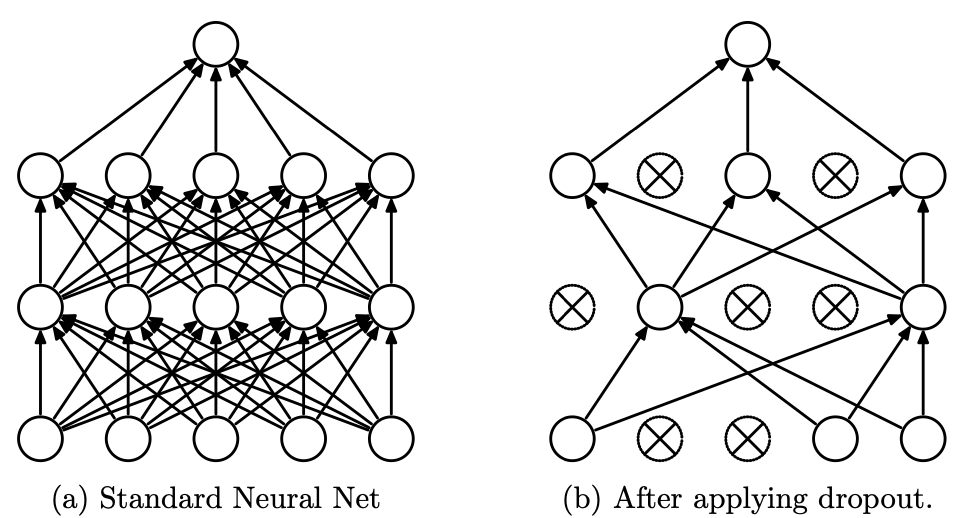

Image ref -> https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf


In [5]:
# Dropout: 
display(Image(image_path + 'Dropout.png', width=600, unconfined=True))
print('Image ref -> https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf')

## 5.5 - Batch Normalisation:

Batch normalization is a technique used in deep learning to tackle the problem known as internal covariate shift. For each layers output becomes the input for the next layer in the hidden layers. As the model updates after each training iteration using gradient descent, the distribution of the activations changes as well, hence this slows down the training process because each layer has to adapt to these new changes.

The batch normalisation operation normalises the output results the from the previous layer and normalises it by subtracting the batch mean and then divides it by the batch standard deviation.
As the batches in Stochastic Gradient descent are randomly sampled, this also means that the data won't be normalised the same way twice, therefore, the network learns to deal with these fluctuations making it more robust and generalise better.

Note: In TF code implementation, "tf.nn.batch_normalization()" and in Keras API implementation, "tf.kears.layers.BatchNormalization()".

## 5.6 - TF and Keras implementation: Adding Regularisation to the model.

### 5.6.1 - Load in the Data:

In [6]:
# Define the number of classes:
nb_classes = 10

# Define the image dimensions:
img_rows, img_cols, img_chnls = 28, 28, 1

# Define the input shape:
input_shape = (img_rows, img_cols, img_chnls)

# Load in the dataset:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

### 5.6.2 - Data Preprocessing:

NOTE: the "*input_shape" where the single " * " notation in the code means a to create a tuple from this argument. where two " * " like " ** " is to create a dictionary.

In [7]:
# Normalise the data:
x_train, x_test = x_train / 255.0, x_test / 255.0

# Inspect:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [8]:
# Reshape the inputs:
x_train = x_train.reshape(x_train.shape[0], *input_shape)
x_test = x_test.reshape(x_test.shape[0], *input_shape)

# Inspect:
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### 5.6.3 - Take a subset of the data: to demonstrate regularisation.

In [9]:
nb_subset = 200

In [10]:
# Taking 200 training samples:
x_train_subset, y_train_subset = x_train[:nb_subset], y_train[:nb_subset] 

print('Training data subset: {}'.format(x_train_subset.shape))
print('Testing data subset: {}'.format(x_test.shape))

Training data subset: (200, 28, 28, 1)
Testing data subset: (10000, 28, 28, 1)


### 5.6.4 - Manually Apply the Regularisation Losses:

This section will show the addition of regularisation loss to __any__ layer. This begins with the SimpleConvolutionalLayer.

In [11]:
# Import the required libraries:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, 
                                     Conv2D, MaxPooling2D, Dropout, BatchNormalization)

### Define the Global Variables:

In [12]:
epochs = 200
batch_size = 32

In [13]:
@ tf.function
def conv_layer(x, kernels, bias, s):
    z = tf.nn.conv2d(x, kernels, strides = [1, s, s, 1], padding = 'VALID')
    
    # Add the bias and activation function:
    return tf.nn.relu(z + bias)

class SimpleConvolutionalLayer(tf.keras.layers.Layer):
    
    def __init__(self, nb_kernels=32, kernel_size=(3, 3), strides=1):
        """ This initialises the Conv-Layer.
        Parameters:
            - nb_kernels: Number of Kernels for the convolution operation.
            - kernel_size: Kernel size (H x W)
            - strides: Vertical and horizontal stride defined as a list.
        """
        # Call the 'Layer' super __init__() method to initialise the hidden mechanisms:
        super().__init__()
        
        # Assign the parameters:
        self.nb_kernels = nb_kernels
        self.kernel_size = kernel_size
        self.strides = strides

        
    def build(self, input_shape):
        """ This builds the Layer by initialising the its parameters based on the input shape.
            This func. will be internally called for the first time the layer is used (it can 
            also be called manually).
            
        Parameters:
            - input_shape: Input shape of the layer is (B x H x W x C)
        
        Additional info.:
            - (B x H x W x C) is (batch size x height x width x depth)
        """
        # Define the Input Channels (assumes the shape format to be BHWC):
        nb_input_channels = input_shape[-1]
        
        # Define the shape of the Tensor of the Kernel:
        kernels_shape = (*self.kernel_size, nb_input_channels, self.nb_kernels)
        
        # Initialise the Kernels with values from the Glorot Distribution:
        glorot_uni_initialiser = tf.initializers.GlorotUniform()
        
        # Make the Kernel variable trainable: by using the "add_weights" method.
        self.kernels = self.add_weight(name = 'kernels',
                                      shape = kernels_shape,
                                      initializer = glorot_uni_initialiser,
                                      trainable = True)
        # Add the Bias to make the Kernel variable trainable:
        self.bias = self.add_weight(name = 'bias',
                                    shape = (self.nb_kernels, ),
                                    initializer = 'random_normal', # Normal distribution.
                                    trainable = True)
    
    def call(self, inputs):
        """ This builds the Call method, to call the layer and perform the operations on the input Tensors.
        Paramters:
            - inputs: Input Tensor
        Returns:
            - returns the Output from "conv_layer"
        """
        return conv_layer(x = inputs, kernels = self.kernels, bias = self.bias, s = self.strides)
    
    def get_config(self):
        """ This is the Helper Functtion to define the layer and its parameters.
        Returns:
            - returns a Dictionary consisting of the layer's configuration.
        """
        return {'nb_kernels': self.nb_kernels,
                'kernel_size': self.kernel_size,
                'strides': self.strides,
                'use_bias': self.use_bias}

#### Extend this layer: by adding kernel/bias regularisation.

This is the "Layer.add_loss()" method will be utilised here.

In [14]:
# Import the required Libraries:
from functools import partial

In [15]:
def l2_reg(coef=1e-2):
    """ This builds the function to compute the weighted L2 norm of the input Tensor.
        (Similar implementation of tf.keras.regularizers.l2())
    Parameters:
        - coef, is the weight for the norm.
    Returns:
        - returns the loss function.    
    """
    return lambda x: tf.reduce_sum(x ** 2) * coef

In [16]:
class Conv_withRegulariser(SimpleConvolutionalLayer):
    def __init__(self, nb_kernels=32, kernel_size=(3, 3), stride=1, 
                 kernel_regulariser=l2_reg(), bias_regulariser=None):
        """ This buuilds the Initialisation Layer.
        Parameters:
            - nb_kernels, is the number of kernels for the convolutions.
            - kernel_size, is the Kernel size of (H x W).
            - stride, is the Vertical and Horizontal strides.
            - kernel_regulariser, is an optional param. and is the Regularisation loss of the kernel variable.
            - bias_regulariser, is an optional param. and is the Regularisation loss of the bias variable.
        """
        # Inherits the parameters of SimpleConvolutionalLayer and initialises it.
        super().__init__(nb_kernels, kernel_size, stride) 
        self.kernel_regulariser = kernel_regulariser
        self.bias_regulariser = bias_regulariser
    
    def build(self, input_shape):
        """ This builds the layer, by initialising its components
        
        """
        super().build(input_shape)
        
        # Attaches the regularisation loss to the following variables: weights(kernel) and bias.
        if self.kernel_regulariser is not None:
            self.add_loss( partial(self.kernel_regulariser, self.kernels) )
            
        if self.bias_regulariser is not None:
            self.add_loss( partial(self.bias_regulariser, self.bias) )
    

When the above Regularised Convolution layers are instantiated, the regulariser will be passed as attributes that will be attached to the layer. Note that the loss values for these regularisers can be obtained by calling ".losses". Demonstrated in the next section.

### 5.6.5 - Test the "Conv_withRegulariser":

This section will show how ".losses" can be called and be printed out.

In [17]:
# Make an instance of the convolutional layer with regularisatio:
conv_reg = Conv_withRegulariser(
                                nb_kernels=32, 
                                kernel_size=(3, 3), 
                                stride=1, 
                                kernel_regulariser=l2_reg(coef=1.0), 
                                bias_regulariser=l2_reg(coef=1.0)
                               )

# Build the layer: input the tensor.
conv_reg.build(input_shape = tf.TensorShape( (None, 28, 28, 1) ))


# Call the Layer's Losses:
reg_losses = conv_reg.losses
# Print out the losses:
print('Regularisation losses over kernel and bias parameter: {}'.format( [loss.numpy() for loss in reg_losses] ))

# Compare "reg_losses" with L2 norms of its kernel and bias parameters:
kernel_norm, bias_norm = tf.reduce_sum(conv_reg.kernels ** 2).numpy(), tf.reduce_sum(conv_reg.bias ** 2).numpy()
# Print out the compared losses:
print('L2 norm of kernel and bias parameters: {}'.format( [kernel_norm, bias_norm] ))

Regularisation losses over kernel and bias parameter: [2.13608, 0.08409045]
L2 norm of kernel and bias parameters: [2.13608, 0.08409045]


Due to its form of implementation, it also means that the property ".losses" also will list the losses attached to all the layers and models, composing an instance. Below will demonstrate more attached losses from increasing the number of Convolution with Regularisers.

In [18]:
# Instantiate a model: Using the Keras Sequential API.
model = Sequential(
    [Input(shape = input_shape), 
     Conv_withRegulariser(kernel_regulariser=l2_reg(coef=1.0), bias_regulariser=l2_reg(coef=1.0)),
     Conv_withRegulariser(kernel_regulariser=l2_reg(coef=1.0), bias_regulariser=l2_reg(coef=1.0)), 
     Conv_withRegulariser(kernel_regulariser=l2_reg(coef=1.0), bias_regulariser=l2_reg(coef=1.0))
    ]
)

# Print out the losses:
print('Losses that are attached to the model and its layers:\n\r{} ({} losses)'.format(
    [loss.numpy() for loss in model.losses], len(model.losses))
     )

Losses that are attached to the model and its layers:
[1.7536073, 0.09171735, 31.857313, 0.07200442, 32.291435, 0.08647607] (6 losses)


As it can be seen in the above output, the losses are listed and these are the ones attached to the model and its layers.

### 5.6.6 - Build a LeNet-5 model with the above custom layers:

Here, the training will also take into account the regularisation terms.

In [19]:
# Here, the "Model" signifies that the LeNet5 will inherit the API, 
# this is also similar to the 'Layer' API, with additional extensions.

class LeNet5(Model):
    
    def __init__(self, nb_classes, kernel_regulariser=l2_reg(), bias_regulariser=l2_reg()):
        
        # Create the model with its layers:
        super(LeNet5, self).__init__()
        
        # 1st Convolutional block:
        self.conv1 = Conv_withRegulariser(
                                        nb_kernels=6,
                                        kernel_size=(5, 5),
                                        stride=1,
                                        kernel_regulariser=kernel_regulariser,
                                        bias_regulariser=bias_regulariser,
                                    )
        
        # 2nd Convolutional block:
        self.conv2 = Conv_withRegulariser(
                                        nb_kernels=16,
                                        kernel_size=(5, 5),
                                        stride=1,
                                        kernel_regulariser=kernel_regulariser,
                                        bias_regulariser=bias_regulariser,
                                    )
        
        # Add the max pooling layer:
        self.max_pool = MaxPooling2D(pool_size=(2, 2))
        
        # Add the Flattening Layer:
        self.flatten = Flatten()
        
        # Add the input layer of the FC-layer:
        self.dense1 = Dense(units = 120, 
                            activation='relu')
        
        # Add the hidden layer of the FC-layer:
        self.dense2 = Dense(units = 84, 
                            activation='relu')
        
        # Add the output layer of the FC-layer:
        self.dense3 = Dense(units = 10, 
                            activation='softmax')
    
    # Setting up the layers according to the architecture: so that to process the inputs.
    def call(self, x):
        x = self.max_pool( self.conv1(x) )
        x = self.max_pool( self.conv2(x) )
        x = self.flatten(x)
        x = self.dense3(self.dense2(self.dense1(x)))
        return x

#### Setting some variables to format the logs:


In [20]:
log_begin_red, log_begin_blue, log_begin_green = '\033[91m', '\033[94m', '\033[92m'
log_begin_bold, log_begin_underline = '\033[1m', '\033[4m'
log_end_format = '\033[0m'

#### Define the Batch Training and log the metrics:

This will also define the optimiser and slicing of the dataset accordingly to the batch size.

In [21]:
# Define the otimiser:
optimiser = tf.optimizers.SGD()

# Slice the dataset into the batch sizes:
dataset = tf.data.Dataset.from_tensor_slices((x_train_subset, y_train_subset)).batch(batch_size)

# Define the logs' string template:
log_string_template = 'Epoch {0:3}/{1}: main loss = {5}{2:5.3f}{6}; ' + \
                      'reg loss = {5}{3:5.3f}{6}; val acc = {5}{4:5.3f}%{6}'

In [22]:
# Checkout "dataset"
dataset

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>

In [23]:
def train_classifier_onData_MNIST(model, log_frequency=10):
    
    # Compute the average losses:
    avg_main_loss = tf.keras.metrics.Mean(name = 'avg_main_loss', dtype = tf.float32)
    avg_reg_loss = tf.keras.metrics.Mean(name = 'avg_reg_loss', dtype = tf.float32)
    
    # Print the Start of Training Logging:
    print('Training: {}start{}'.format(log_begin_red, log_end_format))
    
    # For each epoch, perform the batched training:
    for epoch in range(epochs):
        # For each batch of this epoch, do:
        for (batch_images, batch_gts) in dataset:
            
            # Use TF to tape the gradients: automatic compute of the derivatives.
            with tf.GradientTape() as grad_tape:
                # Feed forward pass of the data:
                y = model(batch_images)
                # Compute the main loss:
                main_loss = tf.losses.sparse_categorical_crossentropy(batch_gts, y)
                # Lost and add the other losses:
                reg_loss = sum(model.losses)
                loss = main_loss + reg_loss
                
            # Obtain the gradients (from GradientTape) of the combined losses and BackPropagate:
            grads = grad_tape.gradient(loss, model.trainable_variables)
            optimiser.apply_gradients( zip(grads, model.trainable_variables))
            
            # Update the losses dict, to keep a track record:
            avg_main_loss.update_state(main_loss)
            avg_reg_loss.update_state(reg_loss)
        
        # Log additional metrics:
        if epoch % log_frequency == 0 or epoch == (epoch - 1):
            # Validate the model, Compute the accuracy on the TEST data:
            acc= tf.reduce_mean(
                tf.metrics.sparse_categorical_accuracy(tf.constant(y_test), model(x_test))
            ).numpy() * 100
            
            main_loss = avg_main_loss.result()
            reg_loss = avg_reg_loss.result()
            
            print(log_string_template.format(
                epoch, epochs, main_loss, reg_loss, acc, log_begin_blue, log_end_format)
                 )
            
        avg_main_loss.reset_states()
        avg_reg_loss.reset_states()
    
    # Print the End of Training Logging:
    print('Training: {}end{}'.format(log_begin_green, log_end_format))
    
    return model

#### Begin the training:

In [24]:
model = LeNet5(nb_classes,
               kernel_regulariser=l2_reg(coef=0.01),
               bias_regulariser=l2_reg(coef=0.01)
              )

model = train_classifier_onData_MNIST(model, log_frequency=10)

Training: start

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch   0/200: main loss = 2.281; reg loss = 0.098; val acc = 18.320%
Epoch  10/200: main loss = 0.175; reg loss = 0.156; val acc = 75.930%
Epoch  20/200: main loss = 0.006; reg loss = 0.099; val acc = 82.880%
Epoch  30/200: main loss = 0.006; reg loss = 0.060; val acc = 83.250%
Epoch  40/200: main loss = 0.006; reg loss = 0.043; val acc = 83.380%
Epoch  50/200: main loss = 0.005; reg loss = 0.035; val acc = 83.100%
Epoch  60/200: main loss = 0.005; reg loss = 0.030; val acc = 83.050%
Ep

### Observation:

Taking a look at the "reg_loss", it can be seen that this increases while "main_loss" (or Classification loss) is decreasing. In the begining the "main_loss" presents with a higher score, where the model then proceeds to minimise it as intended. This was regardless of the values the kernels or biases were taking. When the classification "main_loss" dropped low enough (at the 30th epoch), the "reg_loss" then began to decrease, which means that it was here that the regularisation was taken into account (or the regularisation was in effect).

### Compare the Models: One with regularisation and One without.

In [25]:
# Instantiate a LeNet5 model without Regularisation:

model = LeNet5(nb_classes,
               kernel_regulariser=None,
               bias_regulariser=None
              )

model = train_classifier_onData_MNIST(model, log_frequency=10)

Training: start

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch   0/200: main loss = 2.302; reg loss = 0.000; val acc = 15.330%
Epoch  10/200: main loss = 0.619; reg loss = 0.000; val acc = 72.350%
Epoch  20/200: main loss = 0.001; reg loss = 0.000; val acc = 82.340%
Epoch  30/200: main loss = 0.001; reg loss = 0.000; val acc = 82.390%
Epoch  40/200: main loss = 0.000; reg loss = 0.000; val acc = 82.430%
Epoch  50/200: main loss = 0.000; reg loss = 0.000; val acc = 82.500%
Epoch  60/200: main loss = 0.000; reg loss = 0.000; val acc = 82.570%
Ep

### Observation:

According to the Validation accuracy of the non-regularised model, the achieved value was 79%, and comparing this to the regularised model (at ~ 82%), it can be said that the regularised model achieved a better overall performance, although, not by much.

### Key Take-aways:

The main goal of this notebook was to show the different ways and usage of "add_loss()" method which can be found in Section 5.6.4, and ".losses" method in Section 5.6.5. These can proved to be useful down the line for the development of more complex models and that there is a need to apply layer-specific losses. 

It should also be noted that TF and Keras has provided a more simpler way to implement regularisation to models, and this can be seen in the next section.

## 5.7 - TF and Keras implementation: Applying Different types of Regularisation Methods:

This section will utilise the pre-implemented regularisation methods that are implemented solely with the Keras API. Experiments will be performed with the methods introduced earlier in the notebook for comparison of their effects on the model.

### 5.7.1 - Create another LeNet-5 model: In the Keras Sequential API.  

In [26]:
def lenet(name = 'lenet', input_shape = input_shape, use_dropout = False,
          use_batchnorm = False, regulariser = None):
    """ This builds hte LeNet-5 (KERAS) Model, with the option of using different regularisation methods.
    Parameters:
        - name, is the Name of the model
        - input_shape, is the model's input Tensor shape.
        - use_dropout, a Flag to add Dropout layers after each of the key layers in the model.
        - use_batchnorm, a Flag to add BatchNormalization layers after each of the key layers in the model.
        - regulariser, is input the Regularization function to be applied to the layers' kernels.
    Returns:
        - returns the LeNet-5 Keras model.
    """
    
    layers = []
    
    # ======== Define the 1st Convolutional Block:
    layers += [Conv2D(filters = 6, 
                      kernel_size = (5, 5),  
                      padding ='same', 
                      input_shape = input_shape, 
                      kernel_regularizer = regulariser)
              ]
    
    # Add batchNorm if needed:
    if use_batchnorm:
        layers += [BatchNormalization()]
        
    # Define the Acitvation and MaxPooling for this layer:
    layers += [Activation('relu'), MaxPooling2D(pool_size = (2, 2))]
        
    # Add Dropout if needed:
    if use_dropout:
        layers += [Dropout(rate = 0.25)]
    
    # ======== Define the 2nd Convolutional Block:
    layers += [Conv2D(filters = 16, 
                      kernel_size = (5, 5),  
                      padding ='same', 
                      input_shape = input_shape, 
                      kernel_regularizer = regulariser)
              ]
    
    # Add batchNorm if needed:
    if use_batchnorm:
        layers += [BatchNormalization()]
        
    # Define the Acitvation and MaxPooling for this layer:
    layers += [Activation('relu'), MaxPooling2D(pool_size = (2, 2))]
        
    # Add Dropout if needed:
    if use_dropout:
        layers += [Dropout(rate = 0.25)]
    
    # ======== Define the Fc-Layers:
    # Flatten the input tensors for the FC-layer:
    layers += [Flatten()]
    
    # Define the Input layer of the FC-Layers:
    layers += [Dense(units = 120, 
                     kernel_regularizer = regulariser)]
    # Add batchNorm if needed:
    if use_batchnorm:
        layers += [BatchNormalization()]  
    # Define the Acitvation func:
    layers += [Activation('relu')]
    
    # Define the Hidden layer of the FC-Layers:
    layers += [Dense(units = 84, 
                     kernel_regularizer = regulariser)]
    # Define the Acitvation func:
    layers += [Activation('relu')]
    
    # Define the Hidden layer of the FC-Layers:
    layers += [Dense(units = 10, 
                     activation = 'softmax')]
    
    # Build the Sequential model:
    model = Sequential(layers, name= name)
    
    return model    

### 5.7.2 - Build a LeNet-5 model for each of the listed regularisation techniques:

This section will show the effects of the different types of regularisation methods available in TF and Keras on the training process. To do this, for each of the listed regularisation techniques, an instance of the LeNet model will be instantiated.

#### Define the list of regularisation methods:

In [27]:
configurations = {
    'none':              {'use_dropout': False, 'use_batchnorm': False, 'regulariser': None},
    'L1':                {'use_dropout': False, 'use_batchnorm': False, 'regulariser': tf.keras.regularizers.l1(0.01)},
    'L2':                {'use_dropout': False, 'use_batchnorm': False, 'regulariser': tf.keras.regularizers.l2(0.01)},
    'Dropout':           {'use_dropout': True,  'use_batchnorm': False, 'regulariser': None},
    'BatchNorm':         {'use_dropout': False, 'use_batchnorm': True,  'regulariser': None},
    'L1_with_Dropout':   {'use_dropout': True, 'use_batchnorm': True,  'regulariser': tf.keras.regularizers.l1(0.01)},
    'L1_with_BatchNorm': {'use_dropout': False, 'use_batchnorm': True,  'regulariser': tf.keras.regularizers.l1(0.01)},
    'L1_with_dropout_bn':{'use_dropout': True, 'use_batchnorm': True,  'regulariser': tf.keras.regularizers.l1(0.01)}
}

#### Save each of the model's "history" during Training:

Create a "history" for each of the models to save losses and metrics that were computed during training.

In [28]:
# Define the Batch size: also increases the CUDA processor usage.
batch_size = 1028

# Define the Full dataset for this part:
# dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

In [29]:
# running time calculation
start = timeit.default_timer()

In [30]:
# Create a dictionary to store the training (history) results:
history_per_instance = dict()

# Print out the Training Start logs:
print('Experiment: {0}start{1} (training logs = 0ff)'.format(log_begin_red, log_end_format))

# For each regularisation technique from "configurations" list, instantiate the model:
for config_name in configurations:
    # Set seed: for reproducibility.
    tf.random.set_seed(Seed_nb)
    np.random.seed(Seed_nb)
    
    # Creating each model instance with the regularisation techniques:
    model = lenet('lenet_{}'.format(config_name), **configurations[config_name])
    
    # Compile the model:
    model.compile(optimizer='sgd', 
                  loss= 'sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Launch the training process: Verbose is set to 0, no logs output.
    print("\t> Training with {0}: {1}start{2}".format(config_name, log_begin_red, log_end_format))
    
    history = model.fit(x= x_train, 
                        y= y_train, 
                        batch_size=batch_size, 
                        epochs=300, 
                        validation_data = (x_test, y_test), 
                        verbose = 0)
    
    # Update the history dict:
    history_per_instance[history] = history
    
    # Print out that training is done:
    print("\t> Training with {0}: {1}done{2}".format(config_name, log_begin_green, log_end_format))
    
# Print out the Training Eng logs:
print('Experiment: {0}end{1}'.format(log_begin_green, log_end_format))    


Experiment: start (training logs = 0ff)
	> Training with none: start
	> Training with none: done
	> Training with L1: start
	> Training with L1: done
	> Training with L2: start
	> Training with L2: done
	> Training with Dropout: start
	> Training with Dropout: done
	> Training with BatchNorm: start
	> Training with BatchNorm: done
	> Training with L1_with_Dropout: start
	> Training with L1_with_Dropout: done
	> Training with L1_with_BatchNorm: start
	> Training with L1_with_BatchNorm: done
	> Training with L1_with_dropout_bn: start
	> Training with L1_with_dropout_bn: done
Experiment: end


In [31]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 20.64 Minutes
Time: 0.34 hours


### 5.7.3 - Plot the results:

Here, the training and validation losses and accuracies will be plotted for comparison.

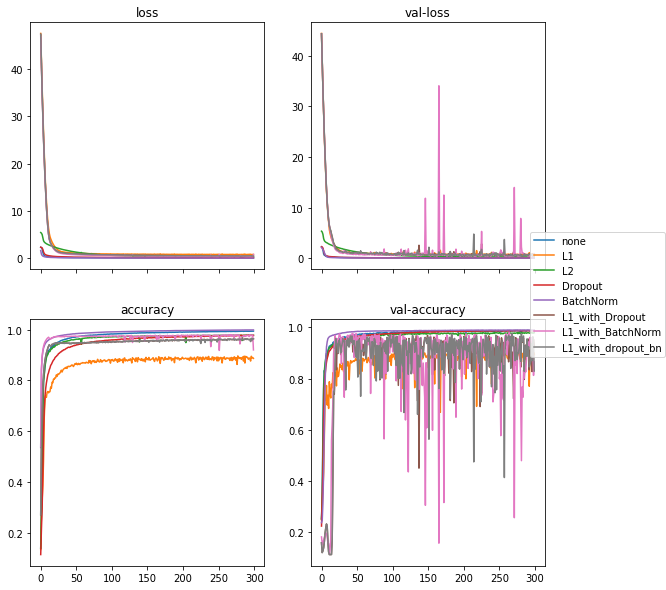

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(10,10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("accuracy")
ax[1, 1].set_title("val-accuracy")

lines, labels = [], []
for config_name, (config_name2, val)  in zip(history_per_instance, configurations.items()):
    history = history_per_instance[config_name]
    ax[0, 0].plot(history.history['loss'])
    ax[0, 1].plot(history.history['val_loss'])
    ax[1, 0].plot(history.history['accuracy'])
    line = ax[1, 1].plot(history.history['val_accuracy'])
    lines.append(line[0])
    labels.append(config_name2)

fig.legend(lines,labels, loc='center right', borderaxespad=0.1)
plt.subplots_adjust(right=0.84)

### 5.7.4 - Print out the Comparison results for each of the Regularisation Technique:

In [33]:
for config_name, (config_name2, val)  in zip(history_per_instance, configurations.items()):
    best_val_acc = max(history_per_instance[config_name].history['val_accuracy']) * 100
    print('Max Validation Accuracy for the model "{}": {:2.2f}%'.format(config_name2, best_val_acc))

Max Validation Accuracy for the model "none": 98.77%
Max Validation Accuracy for the model "L1": 90.35%
Max Validation Accuracy for the model "L2": 97.97%
Max Validation Accuracy for the model "Dropout": 98.75%
Max Validation Accuracy for the model "BatchNorm": 98.96%
Max Validation Accuracy for the model "L1_with_Dropout": 97.16%
Max Validation Accuracy for the model "L1_with_BatchNorm": 98.06%
Max Validation Accuracy for the model "L1_with_dropout_bn": 97.57%


### Conclusion and Observations:

Taking a look at the results and comparing it with baseline (where there isn't a regularisation implemented), majority of the regularisation techniques does improve the model's accuracy and hence it's performance. Interestingly, the model with L1 regularisation did not perform better, this could mean that the weights of the model were penalised too much and resulted in a less accurate model. 

It can also be seen that the L1 regularisation and L1 with Dropout and BatchNorm regularisation does not converge as quickly when compared to the other models, until 150 epochs. There are also obvious fluctuations in validation accuracy during testing for the L1 rgularisation technique, L1 with BatchNorm technique and L1 with Dropout and BatchNorm technique. 

Overall, the idea here is to demonstrate the benefits of using regularisation to combat overfitting of the dataset by these models. 


## Summary:

From this project, I was primarily able to learn and develop my skills in creating the convolutions blocks of the CNN from scratch. This inherently also improved my understanding with OOP style of programming. There were also several implementations of the network such as in TF, Keras Sequential and Functional APIs. I was able to cover the fundamentals of the CNN architecture, such as the convolutions, max/avg pooling, and the effective receptive fields. This project also covered modern techniques, such as different types of optimisers and regularisation methods to improve the CNN's performance and prevention of overfitting on the dataset.